# Machine Learning with XGBoost in Python

### Một số các bước sẽ thực hiện:

1) Lấy dữ liệu phân loại (label/target), chuyển sang loại dữ liệu dạng one-hot encoding

2) Lọc ra các biến độc lập (features) biến đổi dữ liệu về các dạng phù hợp: dạng số (numeric) hoặc dạng phân loại (label)

3) Làm sạch dữ liệu: xử lý dữ liệu bị thiếu, sửa dữ liệu phù hợp trước khi xây dựng mô hình

4) Tạo mô hình

5) Tinh chỉnh mô hình

In [1]:
# Gọi các gói cần thiết cho các bược cần thực hiện:
import pandas as pd # xử lý dữ liệu
import numpy as np # xử lý dữ liệu
from sklearn.preprocessing import OneHotEncoder # biến đổi dữ liệu thành dạng phân loại (label)
from sklearn.model_selection import train_test_split # chia dữ liệu trước khi xây dựng mô hình
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, precision_recall_curve # các chỉ số kiểm tra chất lượng mô hình
import xgboost as xgb # xây dựng mô hình xgboost

In [2]:
# Lấy dữ liệu:
data = pd.read_csv('.../Outbreak_240817.csv')

In [3]:
# Lấy thông tin cơ bản của dữ liệu:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17008 entries, 0 to 17007
Data columns (total 24 columns):
Id                    17008 non-null int64
source                17008 non-null object
latitude              17008 non-null float64
longitude             17008 non-null float64
region                17008 non-null object
country               17008 non-null object
admin1                17008 non-null object
localityName          17008 non-null object
localityQuality       17008 non-null object
observationDate       16506 non-null object
reportingDate         17008 non-null object
status                17008 non-null object
disease               17008 non-null object
serotypes             10067 non-null object
speciesDescription    15360 non-null object
sumAtRisk             9757 non-null float64
sumCases              14535 non-null float64
sumDeaths             14168 non-null float64
sumDestroyed          13005 non-null float64
sumSlaughtered        12235 non-null float64
humans

Một số điểm có thể thấy ở đây như: tổng số lượng bản ghi (observation), các loại dữ liệu của từng trường và các trường dữ liệu nào có dữ liệu bị trống hay không.

In [4]:
# Xem ví dụ 10 dòng dữ liệu:
data.head(10)

,Id,source,latitude,longitude,region,country,admin1,localityName,localityQuality,observationDate,...,speciesDescription,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered,humansGenderDesc,humansAge,humansAffected,humansDeaths
0,230399,OIE,-27.900000,30.800000,Africa,South Africa,KwaZulu-Natal,HPAI_H5N8_2017_019,Exact,17/08/2017,...,"domestic, unspecified bird",248000.0,12.0,12.0,50000.0,0.0,NaN,0.0,NaN,NaN
1,230381,OIE,54.837037,73.354155,Europe,Russian Federation,Omskaya Oblast,Novaya Stanica,Exact,16/08/2017,...,"domestic, swine",122.0,6.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
2,230333,OIE,-21.077740,30.211620,Africa,Zimbabwe,Masvingo,Mwambe,Exact,16/08/2017,...,"domestic, cattle",1283.0,112.0,0.0,NaN,7.0,NaN,NaN,NaN,NaN
3,230396,OIE,-26.000000,28.300000,Africa,South Africa,Gauteng,HPAI_H5N8_2017_020,Exact,15/08/2017,...,"wild, unspecified bird",NaN,1.0,1.0,0.0,0.0,NaN,0.0,NaN,NaN
4,230371,OIE,49.237900,17.700200,Europe,Czech Republic,Jihomoravsky,Hvozdná,Exact,15/08/2017,...,"wild, wild boar",NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
5,230370,OIE,49.237300,17.700800,Europe,Czech Republic,Jihomoravsky,Ostrata,Exact,15/08/2017,...,"wild, wild boar",NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
6,230395,OIE,-26.000000,28.300000,Africa,South Africa,Gauteng,HPAI_H5N8_2017_021,Exact,14/08/2017,...,"domestic, goose",34.0,19.0,19.0,0.0,0.0,NaN,0.0,NaN,NaN
7,230367,OIE,47.771608,33.993286,Europe,Ukraine,Dnipropetrovs'ka,Slovyanka,Exact,14/08/2017,...,"domestic, swine",2.0,2.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN
8,230379,OIE,56.538381,16.119304,Europe,Sweden,Kalmar Laen,Kalmar,Exact,13/08/2017,...,"domestic, chicken",4000.0,1600.0,0.0,4000.0,0.0,NaN,NaN,NaN,NaN
9,230394,OIE,-24.600000,27.200000,Africa,South Africa,Limpopo,HPAI_H5N8_2017_022,Exact,12/08/2017,...,"domestic, unspecified bird",62.0,5.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN


### Một vài điểm về dữ liệu:

Đây là dữ liệu ghi nhận về các trường hợp bị mắc các bệnh từ động vật trong 2 năm như bệnh cúm từ chim, gà...Dữ liệu có bao gồm thông tin:

- Vùng phát sinh bệnh: kinh độ, vĩ đồ, quốc gia, châu lục (longitude, latitude, region, country, admin1, localityName, localityQuality); 

- Thông tin về thời gian phát sinh bệnh(observationDate, reportingDate); 

- Mô tả về bệnh (status, disease, serotypes, speciesDescription, sumAtRisk, sumCases, sumDeaths, sumDestroyed, sumSlaughtered ); và 

- Thông tin về người bị lây nhiễm bệnh (humansGenderDesc, humansAge, humansAffected, humansDeaths).

Chúng ta sẽ đi vào các bước chi tiết đã liệt kê ở phía trên dựa vào một số điểm cơ bản về dữ liệu ở đây.

## Bước 1 - Lấy dữ liệu phân loại và chuyển dữ liệu về dạng one-hot encoding:

Có thể thấy, dữ liệu về người bị nhiễm bệnh sẽ cho ta biết được dữ liệu phân loại cho các dịch bệnh như thế nào. Ở đây, chúng ta có 4 trường thông tin là: humansGenderDesc, humansAge, humansAffected, humansDeaths; trong đó trường humansAffected cho biết người có bị nhiễm bệnh hay không. 

In [5]:
# Kiểm tra thông tin cơ bản:
data[(["humansAge", "humansAffected", "humansDeaths"])].describe()

,humansAge,humansAffected,humansDeaths
count,1068.000000,1417.000000,451.000000
mean,17.701311,1.017643,0.889135
std,26.932867,0.620142,0.321306
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,0.000000,1.000000,1.000000
75%,41.000000,1.000000,1.000000
max,94.000000,24.000000,2.000000


In [6]:
data["humansGenderDesc"].value_counts()

Male      276
Female     84
Name: humansGenderDesc, dtype: int64

Đối với dữ liệu ở đây, chúng ta chỉ quan tâm đến việc con người có bị lây nhiễm bệnh hay không, nên chỉ sử dụng trường humansAffected làm trường phân loại (label/target)

In [7]:
label = data["humansAffected"]
label.value_counts()

1.0     1411
0.0        3
24.0       1
3.0        1
4.0        1
Name: humansAffected, dtype: int64

Với dữ liệu label, chỉ có tổng số 1417/17008 bản ghi có dữ liệu, còn lại là dữ liệu bị trống. Các giá trị của dự liệu bao gồm: 0, 1, 3, 4, 24: đây là các giá trị thể hiện con người bị nhiễm bệnh, trong khi đó, giá trị bị trống thể hiện con người không bị nhiễm bênh. Vậy, trước khi biến đổi dữ liệu này sang dạng one-hot encoding, chúng ta gán lại các giá trị 0, 1, 3, 4, 24 thành True (nhiễm bệnh) - hoặc 1; còn NA thành False - hoặc 0 (không nhiễm bệnh).

In [8]:
# Gán lại dữ liệu:
label = label.replace({1.0: True, 0.0: True, 24.0: True, 3.0: True, 4.0: True, np.nan: False})
label.value_counts()

False    15591
True      1417
Name: humansAffected, dtype: int64

In [9]:
# Biến đổi lại shape của dữ liệu phân loại:
label = np.asarray(label).reshape(-1, 1)

## Bước 2, 3: tạo các  biến độc lập & làm sạch dữ liệu

*Lưu ý*: do dữ liệu về bệnh bao gồm cả dữ liệu dạng số và dữ liệu dạng sắp xếp, và do tính chất khác nhau nên cách xử lý 2 loại dữ liệu này cũng hoàn toàn khác nhau. Để việc xử lý được đơn giản và dễ dàng, chúng ta sẽ tách 2 loại dữ liệu này riêng ra trong quá trình tạo biến độc lập để xử lý, sau khi xử lý xong thì có thể sát nhập lại (merge) để được bộ biến độc lập cần thiết.


### Tạo các biến số:

Trong dữ liệu về bệnh có một số trường thông tin có thể sử dụng được và là dữ liệu dạng số, bao gồm: sumAtRisk, sumCases, sumDeaths, sumDestroyed, sumSlaughtered. Ta sẽ nhóm các biến độc lập này trong 1 bảng dữ liệu riêng.

In [10]:
data_num = data[(["sumAtRisk", "sumCases", "sumDeaths", "sumDestroyed", "sumSlaughtered"])]
data_num.head()

,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered
0,248000.0,12.0,12.0,50000.0,0.0
1,122.0,6.0,1.0,0.0,0.0
2,1283.0,112.0,0.0,NaN,7.0
3,NaN,1.0,1.0,0.0,0.0
4,NaN,1.0,1.0,NaN,NaN


In [11]:
data_num.describe()

,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered
count,9.757000e+03,14535.000000,14168.000000,13005.000000,12235.000000
mean,7.500692e+03,328.183007,199.190147,3765.857978,100.211443
std,4.427669e+04,5821.929892,4109.453986,28355.192298,4341.287763
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.100000e+01,1.000000,0.000000,0.000000,0.000000
50%,9.000000e+01,1.000000,1.000000,0.000000,0.000000
75%,7.160000e+02,5.000000,2.000000,5.000000,0.000000
max,2.000000e+06,460000.000000,439799.000000,913590.000000,339006.000000


### Tạo biến sắp xếp:

Các biến mà ta có thể sử dụng làm biến độc lập với dạng dữ liệu sắp xếp như: country (các thông tin về vị trí khác khá tương đồng với country nên có thể loại bỏ); speciesDescription (thông tin về mầm bệnh, nguyên nhân có thể sử dụng trường dữ liệu này). Chúng ta cùng nhìn qua 2 trường dữ liệu này:

In [12]:
data["country"].value_counts(dropna=False)

France                                       2721
China                                        1465
Estonia                                       927
Albania                                       858
Russian Federation                            795
Latvia                                        742
Serbia                                        662
Saudi Arabia                                  653
Lithuania                                     622
Republic of Korea                             508
Italy                                         486
Poland                                        455
Indonesia                                     425
Egypt                                         411
Nigeria                                       352
Hungary                                       332
Germany                                       322
Bulgaria                                      305
Taiwan (Province of China)                    269
Greece                                        255


Như vậy trường country chỉ lưu dữ liệu là tên các quốc gia phát sinh bệnh

In [13]:
data["speciesDescription"].value_counts()

domestic, cattle                                                                                                                         4913
wild, wild boar                                                                                                                          2670
domestic, chicken                                                                                                                        1682
domestic, duck                                                                                                                           1227
domestic, unspecified bird                                                                                                                808
domestic, sheep                                                                                                                           684
domestic, swine                                                                                                                           675
wild,m

Trường speciesDescription cho biết mầm bệnh xuất phát từ loại động vật nào, và động vật là thú nuôi (domestic) hay hoang dã (wild). Trường thông tin này chứa khá nhiều thông tin và cần xử lý nhiều để được dạng dữ liệu mong muốn. Nên chúng ta có thể xử lý trường country trước.

In [14]:
# Xử lý dữ liệu về quốc gia:
country = data["country"]
# Biến đổi dữ liệu thành dạng one-hot encoding:
country_dump = pd.get_dummies(country)
country_dump.head()

,Albania,Algeria,Angola,Argentina,Armenia,Austria,Bahrain,Bangladesh,Belgium,Belize,...,Uganda,Ukraine,United Arab Emirates,United Republic of Tanzania,United States of America,Uruguay,Viet Nam,West Bank,Zambia,Zimbabwe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Như vậy trường country được kéo ra thành dạng cột, với các quốc gia nào có phát sinh bệnh sẽ được đánh giá trị 1, còn không sẽ được đánh giá trị 0. Dữ liệu này tạm thời thỏa mãn yêu cầu của chúng ta.

Giờ ta chuyển sang trường dữ liệu **speciesDescription**

In [15]:
speciesDescription = data.speciesDescription
speciesDescription.head()

0    domestic, unspecified bird
1               domestic, swine
2              domestic, cattle
3        wild, unspecified bird
4               wild, wild boar
Name: speciesDescription, dtype: object

In [16]:
# Kiểm tra từ đầu tiên của mô tả:
speciesDescription.str.extract(r'(^\w+)', expand=False).value_counts(dropna=False)

domestic         11230
wild              3979
NaN               1648
environmental      129
captive             22
Name: speciesDescription, dtype: int64

Phần lớn thông tin về động vật là vật nuôi (domestic), phần còn lại là động vật hoang dã, bị bắt hoặc trong khuôn viên, môi trường nhân tạo, được quy hoạch. Ngoài ra, 1 lượng không nhỏ thông tin mầm bệnh không được ghi nhận (NaN).

Nhưng chúng ta vừa đề cập ử trên, thông tin về động vật lây nhiễm bệnh và loại động vật được ghi nhận trong trường dữ liệu này. Chúng ta có thể đoán được vật nuôi (gia súc, gia cầm) - domestic có khả năng lây nhiễm bệnh  cao hơn so với động vật hoang dã (wild), do đó, chúng ta có thể tạo ra một biến mới, thể hiện động vật là vật nuôi hay hoang dã

In [17]:
# Bổ sung biến isdomestic vào bảng dữ liệu data_num 
data_num["isdomestic"] = data['speciesDescription'].str.contains('domestic', regex=True).astype('bool')
data_num.head()

/home/ddpham/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered,isdomestic
0,248000.0,12.0,12.0,50000.0,0.0,True
1,122.0,6.0,1.0,0.0,0.0,True
2,1283.0,112.0,0.0,NaN,7.0,True
3,NaN,1.0,1.0,0.0,0.0,False
4,NaN,1.0,1.0,NaN,NaN,False


In [18]:
# Kiểm tra từ cuối của mô tả:
speciesDescription.str.extract(r'(\w+$)', expand=False).value_counts(dropna=False)

cattle          4945
boar            2671
NaN             2257
chicken         1708
duck            1403
bird            1071
sheep            988
swine            681
goose            216
swan             166
turkey           156
horse             77
sample            66
mammal            62
gull              51
anatidae          49
mallard           43
ostrich           41
buzzard           35
ducks             33
equidae           29
quail             28
goat              26
heron             22
crane             18
camelidae         16
dog               16
falcon            16
pigeon            11
crow              10
                ... 
coot               4
cat                4
rook               4
magpie             4
pheasant           3
pochard            3
jackal             3
teal               3
scaup              2
goldeneye          2
wigeon             2
xpeacock           2
deer               1
pintail            1
emu                1
robin              1
yaks         

Phần lớn dữ liệu nhận được cho ta biết động vật nào là nguyên nhân của mầm bệnh, tuy nhiên có tới 2257 trường hợp trả về giá trị NaN, trong đó 1648 trường hợp là không ghi nhận nguyên nhân (không có thông tin trong mô tả - như đã nêu ở trên), số còn lại chúng ta cần kiểm tra tại sao lại không có kết quả như mong muốn.

In [19]:
# Kiểm tra các giá trị cuối cùng không phải là chữ:
speciesDescription.str.extract(r'(\W+$)', expand=False).value_counts()

))    485
      108
)      16
Name: speciesDescription, dtype: int64

Chúng ta sẽ đi tìm hiểu chi tiết hơn về các tình huống ở trên, bắt đầu với "(("

In [20]:
speciesDescription[speciesDescription.str.contains(r'([)]{2}$)')==True].unique()

/home/ddpham/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


array(['wild,mute swan (cygnus olor))',
       'wild,egyptian goose (alopochen aegyptiacus))',
       'domestic,phasianidae (phasianidae))',
       'wild,accipitridae (accipitridae))',
       'domestic,unspecified bird,domestic,phasianidae (phasianidae))',
       'wild,white tailed eagle (haliaeetus albicilla))',
       'wild,mallard,wild,black swan (cygnus atratus))',
       'wild,herring gull,wild,common eider (somateria mollissima))',
       'wild,great black-backed gull (larus marinus))',
       'wild,dalmatian pelican (pelecanus crispus))',
       'wild,eurasian wigeon (anas penelope))',
       'wild,unspecified bird,wild,anatidae,wild,stork,captive,phasianidae (phasianidae))',
       'wild,great egret (ardea alba))',
       'wild,eurasian collared dove (streptopelia decaocto))',
       'captive,indian peafowl (pavo cristatus))',
       'wild,mute swan (cygnus olor), wild, great cormorant (phalacrocorax carbo))',
       'wild,great cormorant (phalacrocorax carbo))',
       'wild,g

Có thể thấy phần thông tin trong ngoặc --(...))-- là mô tả chi tiết giống động vật lây bệnh, tuy nhiên, chúng ta có thể giản lược thông tin này để lấy phần thông tin phía trương của nó. Phần thông tin này chúng ta có thể bỏ đi để có thể lấy được thông tin cần thiết.

In [21]:
speciesDescription[speciesDescription.str.contains(r'( [(]\w+ \w+[)]{2})|( [(]\w+[)]{2})$')==True].str.replace(r'( [(]\w+ \w+[)]{2})|( [(]\w+[)]{2})$', '').str.extract(r'(\w+$)')[0].value_counts()

/home/ddpham/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


swan            342
wigeon           29
eagle            28
gull             24
cormorant         8
egret             6
phasianidae       5
crow              5
pochard           4
accipitridae      4
goose             4
grebe             3
owl               3
pintail           2
tern              2
eider             2
elephant          2
pelican           2
flamingo          2
peafowl           2
dove              1
blackbird         1
shelduck          1
Name: 0, dtype: int64

In [22]:
# Kiểm tra phần mô tả kết thúc với chỉ "(":
speciesDescription[speciesDescription.str.contains(r'(\w+[)])$')==True]

/home/ddpham/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


2763     wild,accipitridae (accipitridae), wild, wild d...
3021     wild,accipitridae (accipitridae), wild, wild d...
3487     wild,mute swan (cygnus olor), wild, whooper swan)
3735     wild,mute swan (cygnus olor), wild, greater wh...
3868     captive,guinea fowl,domestic,indian peafowl (p...
4066     wild,mute swan (cygnus olor), wild, greylag go...
4105        wild,mute swan (cygnus olor), wild, wild duck)
4834     wild,mallard,wild,greylag goose,wild,wild duck...
5020     wild,eurasian wigeon (anas penelope), wild, gr...
5639     wild,eurasian wigeon (anas penelope), wild, gr...
5903        wild,mute swan (cygnus olor), wild, wild duck)
6285     wild,bean goose (anser fabalis), wild, greater...
7266     wild,gull,wild,mute swan (cygnus olor), wild, ...
7597     wild,great black-backed gull (larus marinus), ...
8541     wild,ruddy shelduck,wild,common coot,wild,mall...
12424    wild,brown headed gull,wild,great black-headed...
Name: speciesDescription, dtype: object

In [23]:
speciesDescription[3735]

'wild,mute swan (cygnus olor), wild, greater white-fronted goose)'

Có vẻ như đây là một lỗi nhỏ trong quá trình nhập liệu khi dấu ")" được bổ sung ở cuối câu. Đồi với các tình huống này, ta chỉ đơn thuần xóa đi dấu ")".

In [24]:
speciesDescription[speciesDescription.str.contains(r'(\w+[)])$')==True].str.replace('([)]{1})$', '').str.extract(r'(\w+$)')[0].value_counts()

/home/ddpham/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


duck     6
goose    6
gull     2
stint    1
swan     1
Name: 0, dtype: int64

In [25]:
# Kiểm tra phần mô tả có ký tự cuối cùng là dấu cách - space:
speciesDescription[speciesDescription.str.contains(r'([ ]+)$')==True].value_counts()

/home/ddpham/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


domestic, goat/sheep                                                             98
domestic, cattle, domestic, goat/sheep                                            6
domestic, cattle, domestic, horse, domestic, goat/sheep                           2
wild, accipiter gentilis                                                          1
domestic, cattle, domestic, camelidae, domestic, horse, domestic, goat/sheep      1
Name: speciesDescription, dtype: int64

Đây cũng là một lỗi nhỏ trong quá trình nhập liệu khi dấu space xuất hiện ở cuối câu, ta cũng cần xóa bỏ ký tự này để lấy được dữ liệu mong muốn. Ngoài ra, chúng ta cũng để ý thấy dữ liệu mô tả có ghi nhận "goat/sheep" là 1 trong 2 loại đồng vật lây bệnh, để đơn giản hóa, ta có thể biến đổi dữ liệu này thành goat - hoặc sheep.

#### Thực hiện các bước làm sạch dữ liệu

In [26]:
## Thực hiện các bước làm sạch dữ liệu mô tả:
# Xóa dấu cách cuối dòng:
speciesDescription = speciesDescription.str.replace(r'([ ]+)$', '')
# Xóa cụm từ và "))" cuối dòng:
speciesDescription = speciesDescription.str.replace(r'( [(]\w+ \w+[)]{2})|( [(]\w+[)]{2})$', '')
# Xóa ")" cuối dòng:
speciesDescription = speciesDescription.str.replace('([)]{1})$', '')
# Thay goat/sheep bằng goat:
speciesDescription = speciesDescription.str.replace(r'(goat/sheep)', 'goat')
# Lấy ký tự cuối cùng:
species = speciesDescription.str.extract(r'(\w+$)')

In [27]:
# Kiểm tra giá trị của trường mới:
species[0].value_counts(dropna=False)

cattle          4945
boar            2671
chicken         1708
NaN             1651
duck            1409
bird            1071
sheep            988
swine            681
swan             509
goose            226
turkey           156
goat             133
gull              77
horse             77
sample            66
mammal            62
anatidae          49
mallard           43
ostrich           41
buzzard           35
ducks             33
wigeon            31
equidae           29
quail             28
eagle             28
heron             22
crane             18
dog               16
falcon            16
camelidae         16
                ... 
pheasant           3
xpeacock           2
elephant           2
peafowl            2
flamingo           2
scaup              2
tern               2
goldeneye          2
eider              2
kestrel            1
blackbird          1
openbill           1
robin              1
emu                1
ibex               1
gadwall            1
dove         

Sau khi đã xử lý một số lỗi dữ liệu thì trường species mới tạo ra đã bao gồm được tất cả các động vật được mô tả, tuy nhiên, vẫn có 1651 bản ghi không có thông tin do trường speciesDescription ban đầu không có thông tin.

In [28]:
# Chuyển đổi dữ liệu động vật thành dạng one-hot encoding:
species_dump = pd.get_dummies(species[0])
species_dump.head()

,accipitridae,anatidae,bird,blackbird,boar,buffaloe,buzzard,camelidae,canine,cat,...,stint,stork,swan,swine,teal,tern,turkey,wigeon,xpeacock,yaks
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Như vậy chúng ta đã có đầy đủ các biến độc lập và đã được xử lý qua về chất lượng dữ liệu. Giờ ta có thể gộp các biến độc lập lại với nhau

In [29]:
# Gộp biến độc lập lại với nhau:
X = pd.concat([data_num, species_dump, country_dump], axis=1)

### Tạo dữ liệu train và test

In [30]:
# Tạo ra dữ liệu train và test:
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=.3, random_state=42)

## Bước 4: Xây dựng mô hình

Trước khi bắt tay vào việc xây dựng mô hình, chúng ta sẽ biến đổi dữ liệu train và test về dạng dữ liệu matrix của gói xgboost để thuận tiện cho việc train và test mô hình.

In [31]:
# Biến đổi dữ liệu sang dang DMatrix (dữ liệu dạng matrix của xgboost):
features = X.columns
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [32]:
# Tạo tham số cho mô hình:
num_round = 100 # số lượng lần train mô hình
watchlist = ([dtest, 'val'], [dtrain, 'train'])
param = {
    'max_depth': 5 # chiều sâu của tree
    , 'eta': 0.5 # learning_rate; có giá trị từ 0-1
    , 'nthreads': 4 # số lượng rãnh được xử dụng để chạy mô hình
    , 'objective': 'binary:logistic' # loại mô hình sử dụng; ở đây chúng ta sử dụng mô hình logistic cho biến phân loại dạng nhị phân
    , 'eval_metric': ['error', 'auc'] # metrix sử dụng để đánh giá mô hình
    , 'silent': 1 # 0 - ko in kết quả; 1-in kết quả
}

model = xgb.train(param
                 , dtrain
                 , num_round
                 , watchlist
                 )

[0]	val-error:0.020576	val-auc:0.992291	train-error:0.018648	train-auc:0.994302
[1]	val-error:0.0194	val-auc:0.993605	train-error:0.01764	train-auc:0.995548
[2]	val-error:0.018616	val-auc:0.99372	train-error:0.017052	train-auc:0.995591
[3]	val-error:0.018029	val-auc:0.99387	train-error:0.016632	train-auc:0.995707
[4]	val-error:0.017245	val-auc:0.993892	train-error:0.016212	train-auc:0.995718
[5]	val-error:0.017049	val-auc:0.993903	train-error:0.016212	train-auc:0.995733
[6]	val-error:0.016265	val-auc:0.993923	train-error:0.015372	train-auc:0.995742
[7]	val-error:0.015481	val-auc:0.993931	train-error:0.014868	train-auc:0.995751
[8]	val-error:0.015481	val-auc:0.993931	train-error:0.014448	train-auc:0.995761
[9]	val-error:0.014893	val-auc:0.993945	train-error:0.01428	train-auc:0.995766
[10]	val-error:0.014893	val-auc:0.994094	train-error:0.01428	train-auc:0.995943
[11]	val-error:0.014893	val-auc:0.994094	train-error:0.014028	train-auc:0.995947
[12]	val-error:0.014893	val-auc:0.994096	trai

Từ kết quả xây dựng mô hình ở trên ta có thể thấy:

- Mô hình có kết quả error: 0.014893
- Giá trị AUC của mô hình là: 0.995221
- Kết quả sơ bộ cho thấy mô hình khá chuẩn xác.
- Tuy nhiên, kết quả của cả error và AUC có dữ liệu val đều có kế quả kém hơn so với dữ liệu train, điều này cho thấy mô hình đang bị overfit.

Tạm thời chúng ta bỏ qua vấn đề về overfit của mô hình để tìm hiểu thêm những kết quả của mô hình này

In [33]:
# Kiểm tra kết quả các metrix đánh giá mô hình: accuracy; precision; recall:
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
preds = model.predict(dtest) # dự báo xác xuất dựa vào kết quả test
y_preds = (preds >= 0.5) # sử dụng hạn mức 0.5 làm phân loại
y_preds

array([False, False,  True, ...,  True, False,  True])

In [34]:
# Kiểm tra độ chính xác:
print('Accuracy score: %f' %(accuracy_score(y_test, y_preds)))
print('Error rate: %f' % (1-accuracy_score(y_test, y_preds)))
print('Precision score: %f' %(precision_score(y_test, y_preds)))
print('Recall score: %f' %(recall_score(y_test, y_preds)))

Accuracy score: 0.985107
Error rate: 0.014893
Precision score: 0.847561
Recall score: 0.997608


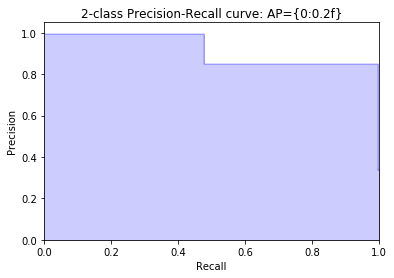

In [35]:
# Vẽ đồ thị về chỉ số precision và recall:
from matplotlib import pyplot as plt
%matplotlib inline
precision, recall, _ = precision_recall_curve(y_test, preds)
plt.step(recall, precision, color='b', alpha=0.2, where='post') 
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall') 
plt.ylabel('Precision')
plt.ylim([0.0, 1.05]) 
plt.xlim([0.0, 1.0]) 
plt.title('2-class Precision-Recall curve: AP={0:0.2f}')
plt.show()

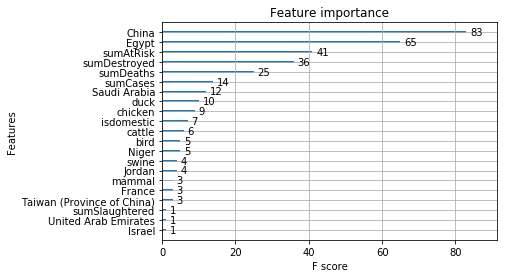

In [36]:
# Vẽ mức độ quan trọng của các biến độc lập:
from xgboost import plot_importance
plot_importance(model)
plt.show()

## Bước 5: tinh chỉnh mô hình:

Như chúng ta đã đề cập về vấn đề overfit của mô hình ngay trong lần đầu xây dựng mô hình, phần lớn thời gian khi sử dụng xgboost chúng ta đều gặp phải vấn đề này. Để giảm thiểu vấn đề overfit, chúng ta có thể chú ý đến một số các yếu tố sau:

- Tinh chỉnh learning_rate & num_round;
- Sử dụng early_stopping_round để chặn việc xây dựng mô hình khi các metric không được cải thiện
- Tinh chỉnh các yếu tố khác như: max_depth, min_child_weight(gama)...

Ta sẽ đi qua một số các yếu tố này để cải thiện kết quả của mô hình:

In [37]:
num_round = 100 # số lượng lần train mô hình
watchlist = ([dtest, 'val'], [dtrain, 'train'])
early_stop = 10 # sử dụng early stop = 5 nếu sau 5 lần train mà chỉ số metric ko cải thiện
#lr = np.arange(0.75, 0.1, -(0.75-0.1)/num_round).tolist() # bổ sung learning_rate, giảm dần sau mỗi lần train
param_new = {
    'max_depth': 3
    , 'eta': 0.75 
    , 'nthreads': 4 
    , 'objective': 'binary:logistic' 
    , 'eval_metric': ['error', 'auc']
    , 'silent': 1 
}

model_new = xgb.train(param_new
                 , dtrain
                 , num_round
                 , watchlist
                 , early_stopping_rounds=early_stop
                 #, learning_rates=lr
                )

[0]	val-error:0.021752	val-auc:0.987006	train-error:0.020748	train-auc:0.988696
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[1]	val-error:0.019596	val-auc:0.993471	train-error:0.018228	train-auc:0.995265
[2]	val-error:0.0194	val-auc:0.993613	train-error:0.01764	train-auc:0.995514
[3]	val-error:0.0194	val-auc:0.993608	train-error:0.01764	train-auc:0.99553
[4]	val-error:0.018616	val-auc:0.993722	train-error:0.017052	train-auc:0.995576
[5]	val-error:0.017441	val-auc:0.99381	train-error:0.016296	train-auc:0.995699
[6]	val-error:0.016657	val-auc:0.993948	train-error:0.015876	train-auc:0.9959
[7]	val-error:0.016265	val-auc:0.993957	train-error:0.015372	train-auc:0.995913
[8]	val-error:0.015481	val-auc:0.993976	train-error:0.014868	train-auc:0.995922
[9]	val-error:0.015481	val-auc:0.994148	train-error:0.014448	train-auc:0.995929
[10]	val-error:0.015481	val-auc:0.994502	train-error:0.014448	train

In [38]:
# Kiểm tra độ chính xác:
preds_new = model_new.predict(dtest)
y_preds_new = (preds_new > .5)
print('Accuracy score: %f' %(accuracy_score(y_test, y_preds_new)))
print('Error rate: %f' %(1-accuracy_score(y_test, y_preds_new)))
print('Precision score: %f' %(precision_score(y_test, y_preds_new)))
print('Recall score: %f' %(recall_score(y_test, y_preds_new)))

Accuracy score: 0.985303
Error rate: 0.014697
Precision score: 0.849287
Recall score: 0.997608


So sánh kết quả này với kết quả trên cho thấy model sau khi được thay đổi một số yếu tố đã có sự tiến bộ hơn. Tuy nhiên, việc overfit của model vẫn chưa được cải thiện rõ ràng.

#### Sử dụng cross-validation để kiểm định lại mô hình đã tinh chỉnh:

Trong xgboost, chúng ta có thể sử dụng cross-validation để kiểm định lại mô hình đã xây dựng, tăng tính chính xác của mô hình. Cách thức thực hiện của cross-validation tương hoàn toàn giống với cách xây dựng mô hình, tuy nhiên, mô hình tạo ra từ cross-validaiton không có tính ứng dụng để dự báo kế quả test (predict) mà chỉnh mang tính kiểm định lại mô hình đã được xây dựng (train).

In [39]:
num_round = 100 # số lượng lần train mô hình
watchlist = ([dtest, 'val'], [dtrain, 'train'])
early_stop = 10 # sử dụng early stop = 5 nếu sau 5 lần train mà chỉ số metric ko cải thiện
#lr = np.arange(0.75, 0.1, -(0.75-0.1)/num_round).tolist() # bổ sung learning_rate, giảm dần sau mỗi lần train
nfold = 5
param_cv = {
    'max_depth': 3
    , 'eta': 0.75
    , 'nthreads': 4 
    , 'objective': 'binary:logistic' 
    , 'eval_metric': ['error', 'auc']
    , 'silent': 0
}

model_cv = xgb.cv(param_cv
                 , dtrain
                 , num_round
                 , nfold
                 , early_stopping_rounds=early_stop
                 )

model_cv[(['train-auc-mean', 'test-auc-mean', 'train-error-mean', 'test-error-mean'])]

,train-auc-mean,test-auc-mean,train-error-mean,test-error-mean
0,0.989411,0.989151,0.021756,0.022260
1,0.994594,0.995001,0.018333,0.018228
2,0.994942,0.995399,0.017871,0.017724
3,0.995458,0.995431,0.017493,0.017640
4,0.995568,0.995557,0.017052,0.017052
5,0.995738,0.995634,0.016023,0.016380
6,0.995862,0.995838,0.015834,0.015960
7,0.995908,0.995899,0.015351,0.015792
8,0.995917,0.995902,0.014994,0.015288
9,0.995922,0.995907,0.014763,0.015120


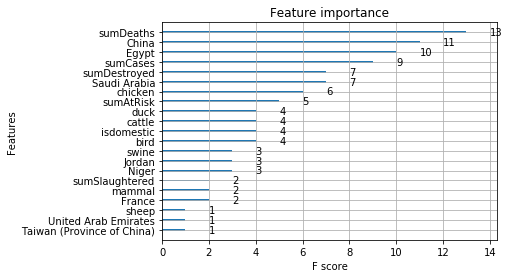

In [40]:
# Vẽ mức độ quan trọng của các biến độc lập:
xgb.plot_importance(model_new)
plt.show()